<a href="https://colab.research.google.com/github/tvelichkovt/LinearRegressionHousePrices/blob/master/LR_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import rc
import unittest

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

def run_tests():
  unittest.main(argv=[''], verbosity=1, exit=False)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load the data

Data [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [2]:
!wget https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv

--2020-08-19 09:59:55--  https://raw.githubusercontent.com/Data-Science-FMI/ml-from-scratch-2019/master/data/house_prices_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460676 (450K) [text/plain]
Saving to: ‘house_prices_train.csv’

house_prices_train. 100%[===================>] 449.88K  --.-KB/s    in 0.06s   

2020-08-19 09:59:55 (7.30 MB/s) - ‘house_prices_train.csv’ saved [460676/460676]



In [3]:
df_train = pd.read_csv('house_prices_train.csv')

# Data exploration

In [4]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

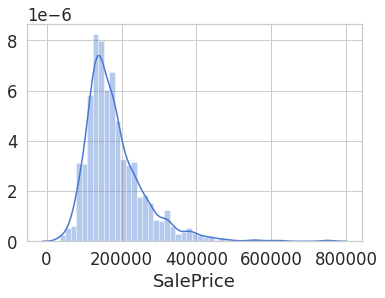

In [5]:
sns.distplot(df_train['SalePrice']);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


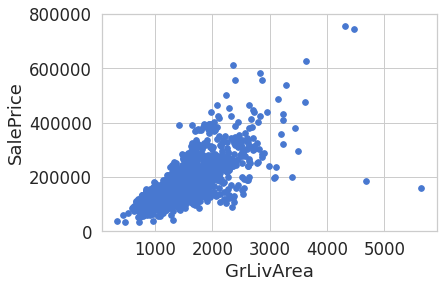

In [6]:
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), s=32);

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


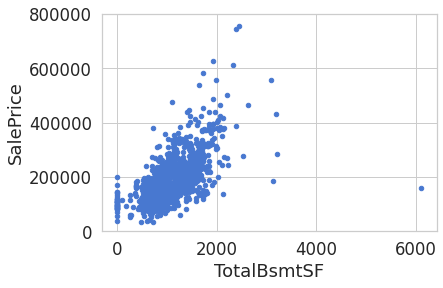

In [7]:
var = 'TotalBsmtSF'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

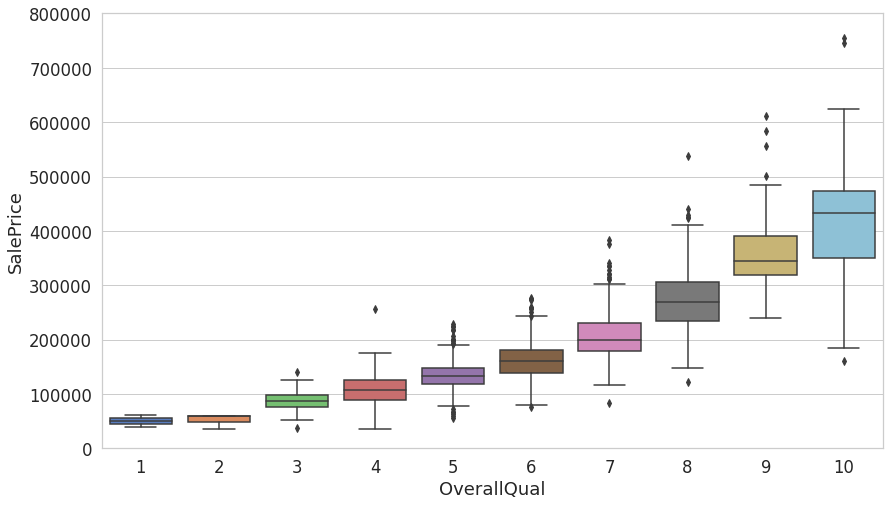

In [8]:
var = 'OverallQual'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
f, ax = plt.subplots(figsize=(14, 8))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

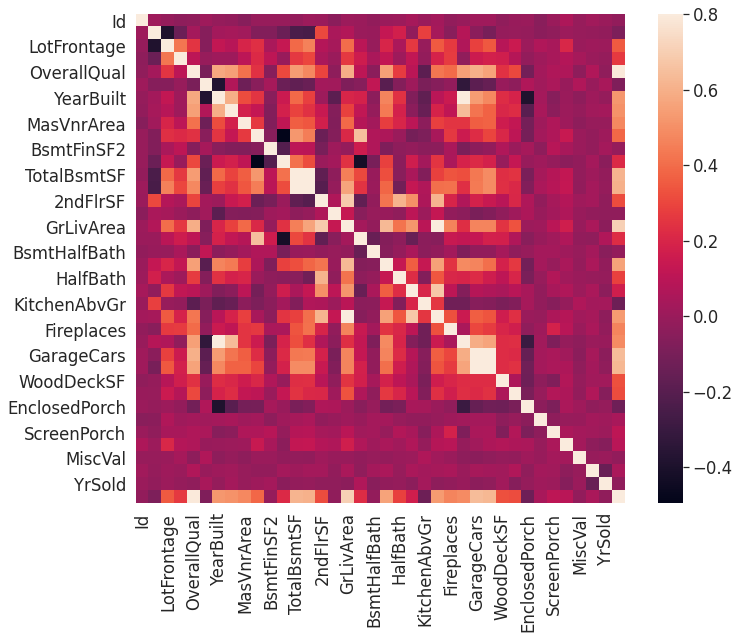

In [9]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

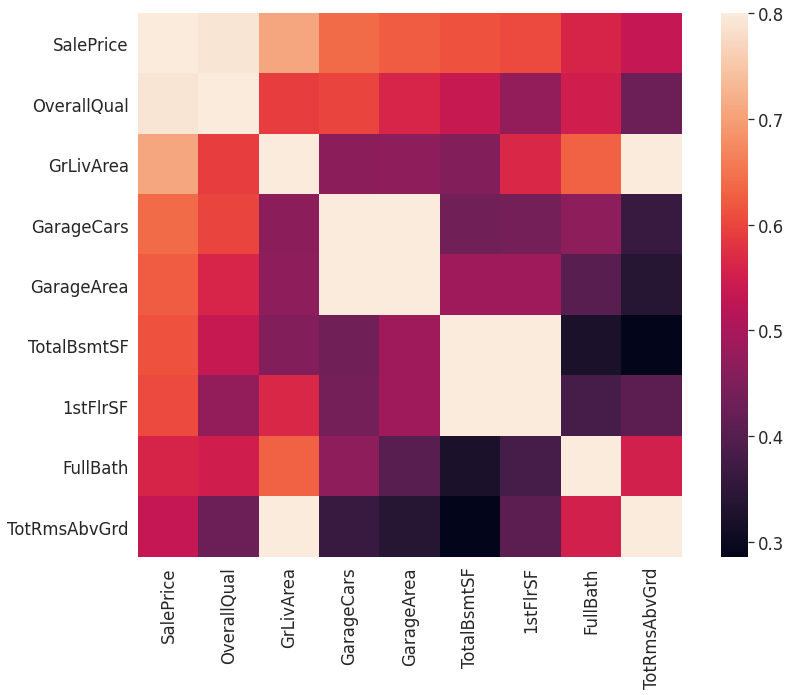

In [10]:
k = 9 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
f, ax = plt.subplots(figsize=(14, 10))
sns.heatmap(df_train[cols].corr(), vmax=.8, square=True);

In [ ]:
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars']
sns.pairplot(df_train[cols], size = 4);

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


## Do we have missing data?

In [ ]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

# Predicting the sale price

## Preparing the data

### Feature scaling

We will do a little preprocessing to our data using the following formula (standardization):

$$x'= \frac{x - \mu}{\sigma}$$

where $\mu$ is the population mean and $\sigma$ is the standard deviation.

![](https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/image_folder_5/FeatureScaling.jpg)

**Source: Andrew Ng**

In [ ]:
x = df_train['GrLivArea']
y = df_train['SalePrice']

x = (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x] 

In [ ]:
x.shape

## Linear Regression

![](https://i.ytimg.com/vi/zPG4NjIkCjc/maxresdefault.jpg)

**Source: MyBookSucks**

Linear regression models assume that the relationship between a dependent continuous variable $Y$ and one or more explanatory (independent) variables $X$ is linear (that is, a straight line). It’s used to predict values within a continuous range, (e.g. sales, price) rather than trying to classify them into categories (e.g. cat, dog). Linear regression models can be divided into two main types:

### Simple Linear Regression

Simple linear regression uses a traditional slope-intercept form, where $a$ and $b$ are the coefficients that we try to “learn” and produce the most accurate predictions. $X$ represents our input data and $Y$ is our prediction.

$$Y = bX + a$$

![](https://spss-tutorials.com/img/simple-linear-regression-equation-linear-relation.png)

**Source: SPSS tutorials**

### Multivariable Regression

A more complex, multi-variable linear equation might look like this, where w represents the coefficients, or weights, our model will try to learn.

$$ Y(x_1,x_2,x_3) = w_1 x_1 + w_2 x_2 + w_3 x_3 + w_0$$

The variables $x_1, x_2, x_3$ represent the attributes, or distinct pieces of information, we have about each observation.

## Loss function

Given our Simple Linear Regression equation:

$$Y = bX + a$$

We can use the following cost function to find the coefficients:

### Mean Squared Error (MSE) Cost Function

The MSE is defined as:

$$MSE = J(W) =  \frac{1}{m} \sum_{i=1}^{m} (y^{(i)} - h_w(x^{(i)}))^2$$

where

$$h_w(x) = g(w^Tx)$$

The MSE measures how much the average model predictions vary from the correct values. The number is higher when the model is performing "bad" on the training set.

The first derivative of MSE is given by:

$$MSE' = J'(W) = \frac{2}{m} \sum_{i=1}^{m} (h_w(x^{(i)}) - y^{(i)})$$


### One Half Mean Squared Error (OHMSE)

We will apply a small modification to the MSE - multiply by $\frac{1}{2}$ so when we take the derivative, the `2`s cancel out:

$$ OHMSE = J(W) =  \frac{1}{2m} \sum_{i=1}^{m} (y^{(i)} - h_w(x^{(i)}))^2 $$

The first derivative of OHMSE is given by:

$$OHMSE' = J'(W) = \frac{1}{m} \sum_{i=1}^{m} (h_w(x^{(i)}) - y^{(i)})$$

In [ ]:
def loss(h, y):
  sq_error = (h - y)**2
  n = len(y)
  return 1.0 / (2*n) * sq_error.sum()

In [ ]:
class TestLoss(unittest.TestCase):

  def test_zero_h_zero_y(self):
    self.assertAlmostEqual(loss(h=np.array([0]), y=np.array([0])), 0)

  def test_one_h_zero_y(self):
    self.assertAlmostEqual(loss(h=np.array([1]), y=np.array([0])), 0.5)

  def test_two_h_zero_y(self):
    self.assertAlmostEqual(loss(h=np.array([2]), y=np.array([0])), 2)
    
  def test_zero_h_one_y(self):
    self.assertAlmostEqual(loss(h=np.array([0]), y=np.array([1])), 0.5)
    
  def test_zero_h_two_y(self):
    self.assertAlmostEqual(loss(h=np.array([0]), y=np.array([2])), 2)

In [ ]:
run_tests()

In [ ]:
class LinearRegression:
  
  def predict(self, X):
    return np.dot(X, self._W)
  
  def _gradient_descent_step(self, X, targets, lr):

    predictions = self.predict(X)
    
    error = predictions - targets
    gradient = np.dot(X.T,  error) / len(X)

    self._W -= lr * gradient
      
  def fit(self, X, y, n_iter=100000, lr=0.01):

    self._W = np.zeros(X.shape[1])

    self._cost_history = []
    self._w_history = [self._W]
    for i in range(n_iter):
      
        prediction = self.predict(X)
        cost = loss(prediction, y)
        
        self._cost_history.append(cost)
        
        self._gradient_descent_step(x, y, lr)
        
        self._w_history.append(self._W.copy())
    return self

In [ ]:
class TestLinearRegression(unittest.TestCase):

    def test_find_coefficients(self):
      clf = LinearRegression()
      clf.fit(x, y, n_iter=2000, lr=0.01)
      np.testing.assert_array_almost_equal(clf._W, np.array([180921.19555322,  56294.90199925]))

In [ ]:
run_tests()

In [ ]:
clf = LinearRegression()
clf.fit(x, y, n_iter=2000, lr=0.01)

In [ ]:
clf._W

In [ ]:
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(clf._cost_history)
plt.show()

In [ ]:
clf._cost_history[-1]

In [ ]:
#Animation

#Set the plot up,
fig = plt.figure()
ax = plt.axes()
plt.title('Sale Price vs Living Area')
plt.xlabel('Living Area in square feet (normalised)')
plt.ylabel('Sale Price ($)')
plt.scatter(x[:,1], y)
line, = ax.plot([], [], lw=2, color='red')
annotation = ax.text(-1, 700000, '')
annotation.set_animated(True)
plt.close()

#Generate the animation data,
def init():
    line.set_data([], [])
    annotation.set_text('')
    return line, annotation

# animation function.  This is called sequentially
def animate(i):
    x = np.linspace(-5, 20, 1000)
    y = clf._w_history[i][1]*x + clf._w_history[i][0]
    line.set_data(x, y)
    annotation.set_text('Cost = %.2f e10' % (clf._cost_history[i]/10000000000))
    return line, annotation

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=300, interval=10, blit=True)

rc('animation', html='jshtml')

anim

# Multivariable Linear Regression

Let's use more of the available data to build a Multivariable Linear Regression model and see whether or not that will improve our OHMSE error:

In [ ]:
x = df_train[['OverallQual', 'GrLivArea', 'GarageCars']]

x = (x - x.mean()) / x.std()
x = np.c_[np.ones(x.shape[0]), x] 

clf = LinearRegression()
clf.fit(x, y, n_iter=2000, lr=0.01)

In [ ]:
clf._W

In [ ]:
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(clf._cost_history)
plt.show()

In [ ]:
clf._cost_history[-1]